In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import sys
import os
from importlib import reload
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from collections import namedtuple, defaultdict
import scipy

In [94]:
home_path = '/data/home/wpw035/Drug_response_prediction/DRP-alpha-preliminary-results'

_train_test_path = f'{home_path}/Unseen_cell_line_testing/test_train_cls'

codebase_path = '/data/home/wpw035/Codebase'
sys.path.insert(0, codebase_path) #add path to my codebase models

In [5]:
#my moudles
from DRP_utils import data_preprocessing as dp_nb
reload(dp_nb)
from DRP_utils import model_selection as ms_nb
reload(ms_nb)
from DRP_utils import testing as t_nb
reload(t_nb)
import Data_imports as di_nb
reload(di_nb)
import pairs_train_test_split as  tts_nb
reload(tts_nb)
import Learning_curve as lc_nb
reload(lc_nb)

<module 'Learning_curve' from '/data/home/wpw035/Drug_response_prediction/DRP-alpha-preliminary-results/Unseen_cell_line_testing/Learning_curve.py'>

In [6]:
#read in data
prot, rna, one_hot_cls, one_hot_drugs, ic50_df1 = di_nb.read_input_data()
_all_cls = prot.index
_all_drugs = ic50_df1.columns

/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Number of missing prot values 0.386335609896865
num non overlapping prot and target cls: 10
num non overlapping rna prot and target cls: 91


In [7]:
prot.shape, rna.shape, one_hot_cls.shape, one_hot_drugs.shape

((877, 8457), (877, 17417), (877, 877), (345, 345))

In [8]:
#create input data for each drug
#just need this for the truth, y values 
x_all, x_drug, y_list  = dp_nb.create_all_drugs(
    rna[['TSPAN6','TNMD']], one_hot_drugs, ic50_df1, _all_cls)
cls_drugs_index = x_all.index + '::' + x_drug.index
#fmt index to include drug cell line paris

x_all.index = cls_drugs_index
x_drug.index = cls_drugs_index
y_list.index = cls_drugs_index
x_all.shape, x_drug.shape, len(y_list)

((263375, 2), (263375, 345), 263375)

In [9]:
y_list

22RV1::(5Z)-7-Oxozeaenol       2.473661
23132-87::(5Z)-7-Oxozeaenol    1.301264
42-MG-BA::(5Z)-7-Oxozeaenol    0.588663
451Lu::(5Z)-7-Oxozeaenol      -3.319106
5637::(5Z)-7-Oxozeaenol        1.626590
                                 ...   
YT::rTRAIL                    -0.556224
ZR-75-30::rTRAIL               1.613187
huH-1::rTRAIL                 -0.725144
no-10::rTRAIL                  0.409970
no-11::rTRAIL                  0.702551
Length: 263375, dtype: float64

In [10]:
#set train size search space. 
lg_space = np.logspace(1, 17.6, base=2.0).astype(int)
#lg_space = np.append(lg_space, len(x_train_rna))
lg_space = np.unique(lg_space)
lg_space

array([     2,      3,      4,      5,      6,      8,     10,     13,
           16,     20,     26,     33,     42,     53,     67,     85,
          108,    136,    173,    219,    277,    350,    443,    560,
          708,    896,   1133,   1433,   1813,   2293,   2900,   3668,
         4638,   5866,   7419,   9383,  11867,  15008,  18980,  24004,
        30358,  38393,  48555,  61407,  77660,  98216, 124212, 157089,
       198668])

In [126]:
#make mean model
class Mean_model():
    def __init__(self, y_train):
        model = defaultdict(list)
        #group cls by drugs
        for ind, val in y_train.iteritems():
            cl, d = ind.split('::')
            model[d].append(val)
            
        #take average of all values for a given drug   
        for d in _all_drugs:
            model[d] = np.mean(model[d])
        
        self.model = model
        
    def predict(self, y_index, reformat=True):
        #reformat index to get just drug
        if reformat:
            y_index = [y.split('::')[1] for y in y_index]
            
        return np.array([self.model[y] for y in y_index])
    
    def replace_nan(self, re='mean'):
        #replace nan's with re, deflat re=0
        for k in self.model:
            if np.isnan(self.model[k]):
                if re=='mean':
                    vals = np.array(list(self.model.values()))
                    vals = vals[~np.isnan(vals)]
                    self.model[k] = vals.mean()
                else:
                    self.model[k] = re
    

In [128]:
for run in range(30):
    test = pd.read_csv(f'{_train_test_path}/test_pairs{run}', 
                       dtype=str, delimiter='/n',header=None)[0].values
    train = pd.read_csv(f'{_train_test_path}/train_pairs{run}', 
                        dtype=str, delimiter='/n',header=None)[0].values
    y_train = y_list.loc[train]
    y_test = y_list.loc[test]

    test_results = {'r2': [], 'mse': [], 'rho' : []}
    for train_size in lg_space:

        #find y subset and create mean model
        y_train_sub = y_train[:train_size]
        mm = Mean_model(y_train_sub)
        #replace nan's from drugs that are not in the train set with zeros
        mm.replace_nan()
        pre = mm.predict(y_test.index)

        #find performance metrics
        test_results['rho'].append(
            scipy.stats.pearsonr(y_test, pre))
        test_results['r2'].append(
            sklearn.metrics.r2_score(y_test, pre))
        test_results['mse'].append(
            sklearn.metrics.mean_squared_error(y_test, pre))
    test_results = pd.DataFrame(test_results)
    test_results['train size'] = lg_space
    test_results.to_csv(f'LC-metric-results/Mean_model/run{run}')

/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/home/wpw035/.conda/envs/tfGPUforge/lib/python3.9/si

In [96]:
test_results

,r2,mse,rho,train_size
0,-0.562481,10.714667,"(0.08294934233021192, 2.761238190164649e-41)",2
1,-0.558363,10.686432,"(0.08363272080957027, 6.089415910274662e-42)",3
2,-0.557774,10.682389,"(0.07581627121271262, 9.371532212740235e-35)",4
3,-0.556917,10.676518,"(0.07493773068972627, 5.439665790867739e-34)",5
4,-0.556594,10.674298,"(0.09819523094001638, 3.2030891032686996e-57)",6
5,-0.559123,10.691640,"(0.10090767538251737, 2.435789611174965e-60)",8
6,-0.550449,10.632159,"(0.10743175321760653, 3.4031865602668473e-68)",10
7,-0.551572,10.639862,"(0.09730561745620181, 3.234235797799478e-56)",13
8,-0.542052,10.574575,"(0.10833063932704246, 2.573257533736022e-69)",16
9,-0.537684,10.544624,"(0.10203982545178678, 1.1464666195301443e-61)",20


In [75]:
mm.replace_nan()

In [67]:
np.nan

nan

In [72]:
np.isnan(mm.model['A-443654'])

True

In [41]:
[mm.model[k] for k in mm.model.keys() if mm.model[k] == np.nan]

[]

In [33]:
len(lg_space)

49

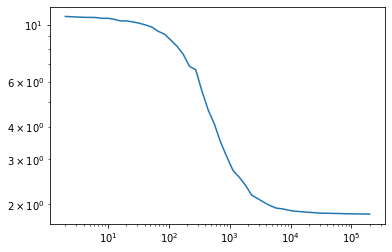

In [88]:
plt.plot(lg_space, test_results['mse'])
plt.xscale('log')
plt.yscale('log')

In [31]:
mm.model

defaultdict(list,
            {'WHI-P97': 4.50822525,
             'EHT-1864': 3.5639797857142854,
             'SB505124': 4.022242666666667,
             'Rucaparib': 3.2309492727272726,
             'Selumetinib': 2.6232948809523813,
             'Trichostatin A': -1.1911789000000002,
             'Kobe2602': 4.53463975,
             'Serdemetan': 2.664824076923077,
             'Dactolisib': -2.396132642857143,
             'CP466722': 2.6882531,
             'LIMK1 inhibitor BMS4': 5.09093575,
             'Amuvatinib': 3.498633625,
             'Daporinad': -2.5014598,
             'PF-4708671': 3.8273267999999994,
             'Alectinib': 3.115902875,
             'GSK429286A': 5.033722200000001,
             'Entinostat': 0.8744578333333335,
             'Alisertib': 1.358561,
             'Z-LLNle-CHO': 0.25707674999999997,
             'IGFR_3801': 0.4602530833333332,
             'C-75': 4.406987166666666,
             'AST-1306': 1.3485064545454544,
             'Capivaser

In [23]:
pre

array([nan, nan, nan, ..., nan, nan, nan])

In [22]:
sum(y_test.isna())

0